In [106]:
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

project_root = Path(".").absolute().parents[1]
print(project_root)

/home/david/bin/python/intensity/src


In [107]:
base_tile_paths = {
    "gt": project_root / "dataset" / "big_tile_no_overlap" / "gt.npy",
    "alt": project_root / "dataset" / "big_tile_no_overlap" / "alt.npy"
}

fixed_tile_paths = {
    "Linear Interpolation + Least Squares Harmonization": project_root / "dataset" / "big_tile_no_overlap" / "fixed_li_lstsq.txt.gz",
    "Deep Learning Harmonization": project_root / "dataset" / "big_tile_no_overlap" / "fixed_dl_5.txt.gz",
    "Histogram Matching": project_root / "dataset" / "big_tile_no_overlap" / "fixed_hm.txt.gz"
    }


In [108]:
tile2 = np.loadtxt(fixed_tile_paths["Linear Interpolation + Least Squares Harmonization"])
gt = np.load(base_tile_paths["gt"])

In [109]:
def checkerboard(t1, t2, width=8):
    # produce a new tile that checkerboards the fixed tile and the ground truth tile
    
    # create structure
    cb_t1 = t1.copy()
    cb_t2 = t2.copy()
    
    # range for X and Y
    x_min, x_max = cb_t1[:, 0].min(), cb_t1[:, 0].max()
    y_min, y_max = cb_t1[:, 1].min(), cb_t1[:, 1].max()
    
    x_dist = x_max - x_min
    y_dist = y_max - y_min
    
    x_step_size = x_dist // width
    y_step_size = y_dist // width
    
    # create bins
    xr = np.arange(x_min, x_max, x_step_size)
    yr = np.arange(y_min, y_max, y_step_size)
    
    xr = np.concatenate((xr, np.array([x_max])))
    yr = np.concatenate((yr, np.array([y_max])))

    t1_indices = np.full(cb_t1.shape[0], False, dtype=bool)
    t2_indices = np.full(cb_t2.shape[0], False, dtype=bool)

    for i in range(len(xr)-1):
        for j in range(len(yr)-1):
            if (i + j) % 2 == 1:
                # 'white' tile --> t2
                new_indices = (
                    (cb_t2[:, 0] < xr[i+1]) &
                    (cb_t2[:, 0] >= xr[i]) &
                    (cb_t2[:, 1] < yr[j+1]) &
                    (cb_t2[:, 1] >= yr[j])
                )
                
                t2_indices = t2_indices | new_indices
                
            else:
                # 'black' tile --> gt
                new_indices = (
                    (cb_t1[:, 0] < xr[i+1]) &
                    (cb_t1[:, 0] >= xr[i]) &
                    (cb_t1[:, 1] < yr[j+1]) &
                    (cb_t1[:, 1] >= yr[j])
                )
                
                t1_indices = t1_indices | new_indices
                    

    return cb_t1[t1_indices], cb_t2[t2_indices]
                

gt_norm = gt.copy()
gt_norm[:, 3] /= 512
cbgt, cbf = checkerboard(gt_norm, tile2)



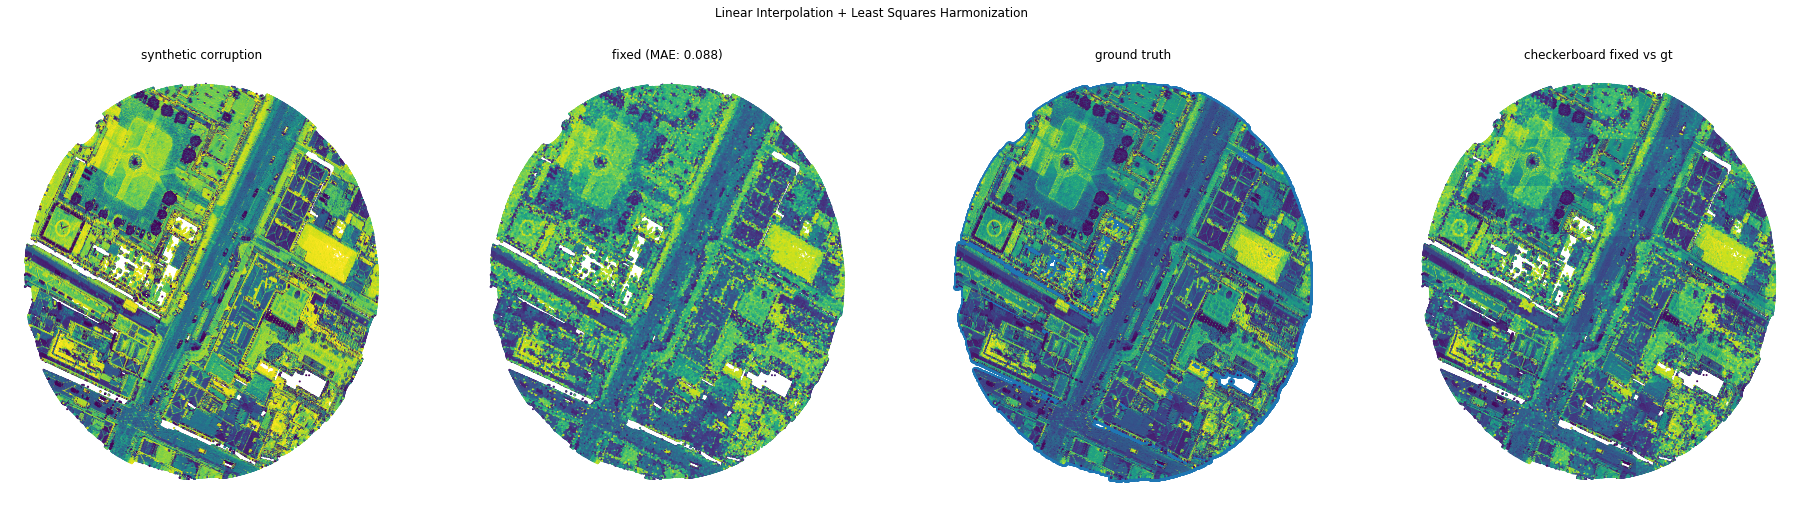

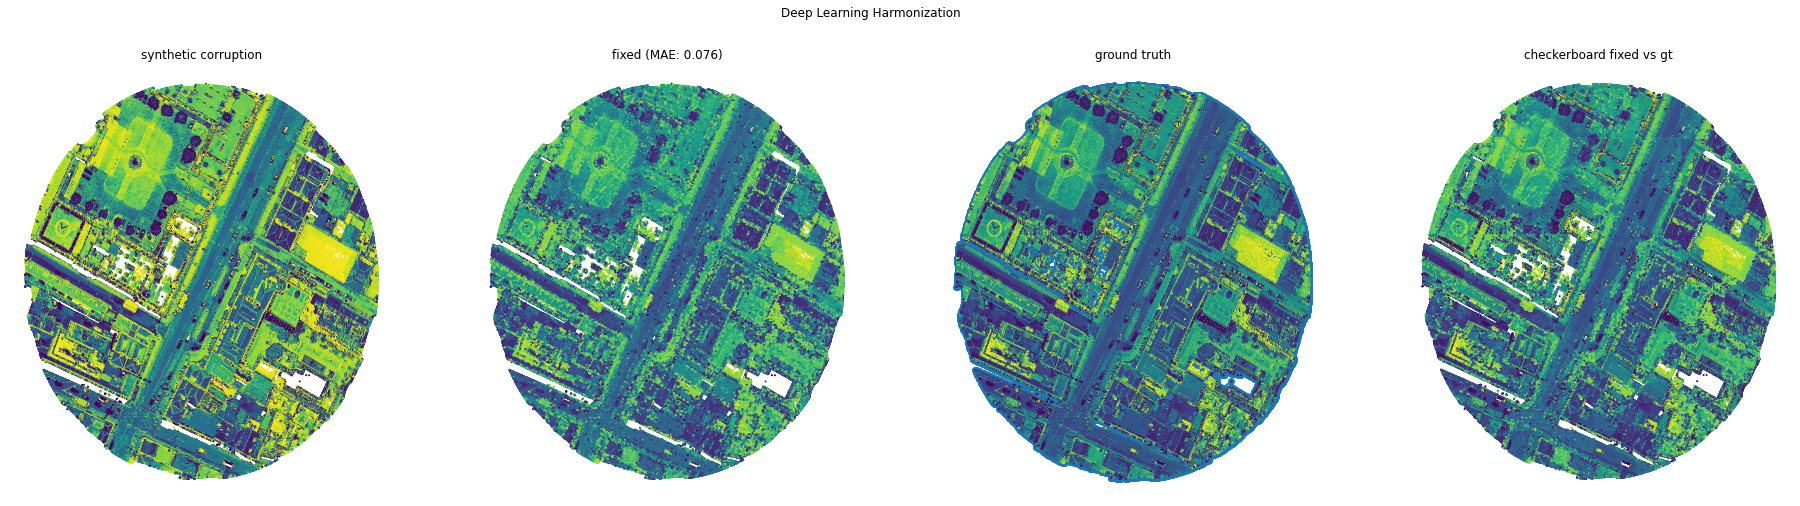

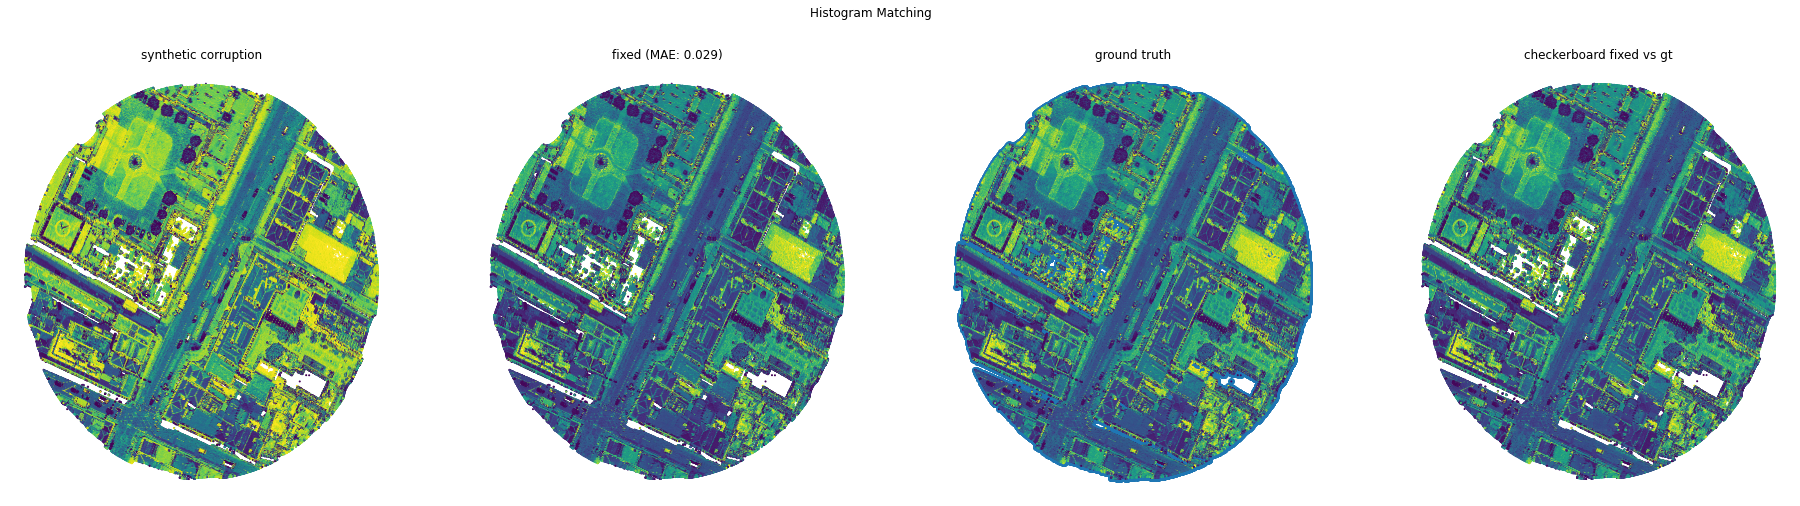

In [110]:
matplotlib.rcParams['figure.figsize'] = [32, 8]

for key, path in fixed_tile_paths.items():
        
    fig, ax = plt.subplots(1, 4)
    fig.suptitle(f"{key}")
    
    tile = np.loadtxt(path)   
    mae = np.mean(np.abs(tile[:, 3] - tile[:, 4]))
    ax.flat[1].scatter(tile[:, 0], tile[:, 1], c=tile[:, 4], s=1, vmin=0, vmax=1)   # fixed tiles have gt and fix channels
    ax.flat[1].set_title(f"fixed (MAE: {mae:.3f})")
    ax.flat[1].axis("off")
    
    tile = [ np.load(base_tile_paths['gt']), np.loadtxt(path) ]
    tile[0][:, 3] /= 512  # normalize
    cb_t1, cb_t2 = checkerboard(tile[0], tile[1])
    ax.flat[3].scatter(cb_t1[:, 0], cb_t1[:, 1], c=cb_t1[:, 3], s=1, vmin=0, vmax=1)
    ax.flat[3].scatter(cb_t2[:, 0], cb_t2[:, 1], c=cb_t2[:, 4], s=1, vmin=0, vmax=1)
    ax.flat[3].set_title("checkerboard fixed vs gt")
    ax.flat[3].axis("off")
    
    tile = np.load(base_tile_paths['gt'])
    ax.flat[2].scatter(tile[:, 0], tile[:, 1])
    ax.flat[2].scatter(tile[:, 0], tile[:, 1], c=tile[:, 3], s=1, vmin=0, vmax=512)
    ax.flat[2].set_title("ground truth")
    ax.flat[2].axis("off")
    
    tile = np.load(base_tile_paths['alt'])
    ax.flat[0].scatter(tile[:, 0], tile[:, 1], c=tile[:, 3], s=1, vmin=0, vmax=512)
    ax.flat[0].set_title("synthetic corruption")
    ax.flat[0].axis("off")
    plt.show()